In [ ]:
# Need to install transformers and datasets each time starting Colab

#!pip install transformers
#!pip install datasets

In [ ]:
import pandas as pd
import io
import numpy as np
import time
import random
import torch
import matplotlib.pyplot as plt
%matplotlib inline

from datasets import load_dataset
from datasets import load_metric
from datasets import Dataset, DatasetDict

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


## Prepare emo Datasets
- Dataset available on HuggingFace: https://huggingface.co/datasets/emo


In [ ]:
# Load data
emo = load_dataset('emo')

emo

Downloading:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.71k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.87M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/495k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emo downloaded and prepared to /root/.cache/huggingface/datasets/emo/emo2019/1.0.0/3bb182a8ea21ffa4656a89f870d16a7b75abb79f07cf990436beb9320d1d6ddd. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 30160
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 5509
    })
})

### Brief EDA
- Examples of texts to be classified
- Distribution of text lengths in data
- Classification category counts and baseline most frequent class calculation

In [ ]:
# Let's look at 5 random examples of text to be classified and their corresponding classification
# Create dict of each class category
class_dict = {0: 'others',
              1: 'happy',
              2: 'sad',
              3: 'angry'}

idx_sample = random.sample(range(len(emo['train'])), 5)
text_samples = emo['train'].select(idx_sample)

for row in text_samples:
  print("Text:", row['text'])
  print("Class: " + str(row['label']) + " - " + class_dict[row['label']])
  print()

Text: if no peace then what will u do because of the implication only implicationsno ur views ideas r ur eishes
Class: 0 - others

Text: i miss my familyfrowningface can understand the feeling  cryingfacecryingface
Class: 2 - sad

Text: doing love my friend i'm good what's up with you very bad
Class: 2 - sad

Text: you are a dumb engine excuse me i'm not a cusp shall i repeat my question lol
Class: 0 - others

Text: i miss  mine yours mines not due for like 2 weeks i miss  my girlfriend
Class: 2 - sad



Avg. Text Length: 13.263627320954907



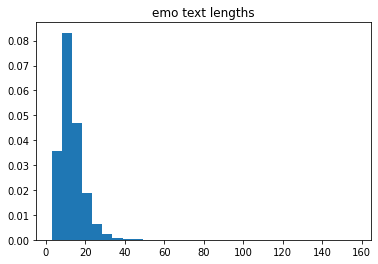

In [ ]:
# get list of text lengths in dataset
len_text = [len(x['text'].split()) for x in emo['train']]

print("Avg. Text Length:", np.mean(len_text))

plt.hist(len_text, density=True, bins=30) 
plt.title("emo text lengths")
print()
plt.show()

In [ ]:
# value counts for categories (create a df to look at value counts)
emo_train_df = pd.DataFrame(emo['train'])
emo_train_df['label'].value_counts()

0    14948
3     5506
2     5463
1     4243
Name: label, dtype: int64

In [ ]:
# Most common classifier calculation
print("Most common class frequency:", np.max(emo_train_df['label'].value_counts()) / len(emo['train']))

Most common class frequency: 0.4956233421750663


### Tokenize Data for DistilBert

In [ ]:
# define tokenizer function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# initialize tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# tokenize
tokenized_datasets = emo.map(tokenize_function, batched=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

  0%|          | 0/31 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [ ]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'text'],
        num_rows: 30160
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'text'],
        num_rows: 5509
    })
})

In [ ]:
# take a look at a tokenized input
print(tokenized_datasets['train']['input_ids'][2])

[101, 2011, 2011, 8224, 18546, 2073, 2017, 2444, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

# Fine-Tune and Evaluate DistilBert Models on emo

In [ ]:
len(emo['train'])

30160

In [ ]:
dataset_name = 'emo'
# training_sizes = [100, 500, 1000, 2000, 3000, 
training_sizes = [5000, 8000]
n_dataset = 30160

results_list = []
for t_size in training_sizes:
    print("Training with size:", str(t_size))
    # get random subset of training data of t_size 
    idx_sample = random.sample(range(n_dataset), t_size)
    small_dataset = tokenized_datasets['train'].select(idx_sample)

    # Fine-tune model
    #################
    # instantiate model
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

    # start with default training args
    training_args = TrainingArguments("test_trainer")
    # change epochs and learning rate
    training_args.num_train_epochs = 4.0
    training_args.learning_rate = 2e-5

    # instantiate trainer
    trainer = Trainer(
        model=model, args=training_args, train_dataset=small_dataset, eval_dataset=tokenized_datasets['test']
    )

    # start timer
    start_time = time.time()

    # fine-tune/train model
    trainer.train()

    # compute training time
    end_time = time.time()
    training_time = round(end_time-start_time)

    # Compute Metrics for Train and Test
    ####################################
    # define compute_metrics
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        precision, recall, f1, _ = precision_recall_fscore_support( labels, predictions, average='weighted')
        acc = accuracy_score(labels, predictions)
        return {
            'accuracy': acc,
            'f1': f1,
            'precision': precision,
            'recall': recall
        }
    
    # create trainer to evaluate training loss metric on small_dataset
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=small_dataset,
        eval_dataset=small_dataset,
        compute_metrics=compute_metrics,
    )

    # get training loss
    train_metrics = trainer.evaluate()
    train_loss = train_metrics['eval_loss']

    # create trainer to evaluate on test data
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=small_dataset,
        eval_dataset=tokenized_datasets['test'],
        compute_metrics=compute_metrics,
    )
    
    # Compile and write results to file
    ###################################
    # create results dict of evaluation on test data and training info
    results = trainer.evaluate()
    results['dataset'] = dataset_name
    results['training_time'] = training_time
    results['training_loss'] = train_loss
    results['training_size'] = t_size

    # append results_list and write to csv at each iteration
    results_list.append(results)
    results_df = pd.DataFrame(results_list)
    results_df.to_csv('/drive/My Drive/W266 - NLP with Deep Learning/Data/emo_results.csv', index = False)

Training with size: 5000


Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

Step,Training Loss
500,0.705200
1000,0.354100
1500,0.268300
2000,0.182600
2500,0.141200


Saving model checkpoint to test_trainer/checkpoint-500
Configuration saved in test_trainer/checkpoint-500/config.json
Model weights saved in test_trainer/checkpoint-500/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-1000
Configuration saved in test_trainer/checkpoint-1000/config.json
Model weights saved in test_trainer/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-1500
Configuration saved in test_trainer/checkpoint-1500/config.json
Model weights saved in test_trainer/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-2000
Configuration saved in test_trainer/checkpoint-2000/config.json
Model weights saved in test_trainer/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-2500
Configuration saved in test_trainer/checkpoint-2500/config.json
Model weights saved in test_trainer/checkpoint-2500/pytorch_model.bin


Training completed. Do not forget to share your mod

The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 5509
  Batch size = 8


loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333


Training with size: 8000


Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.12.5",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991

Step,Training Loss
500,0.675200
1000,0.438600
1500,0.317400
2000,0.299700
2500,0.189500
3000,0.223700
3500,0.131900
4000,0.146500


Saving model checkpoint to test_trainer/checkpoint-500
Configuration saved in test_trainer/checkpoint-500/config.json
Model weights saved in test_trainer/checkpoint-500/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-1000
Configuration saved in test_trainer/checkpoint-1000/config.json
Model weights saved in test_trainer/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-1500
Configuration saved in test_trainer/checkpoint-1500/config.json
Model weights saved in test_trainer/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-2000
Configuration saved in test_trainer/checkpoint-2000/config.json
Model weights saved in test_trainer/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-2500
Configuration saved in test_trainer/checkpoint-2500/config.json
Model weights saved in test_trainer/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-30

The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 5509
  Batch size = 8


### Fine-tune BERT base on full training data and evaluate 

In [ ]:
# tokenize the data
# define tokenizer function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# tokenize
tokenized_datasets = emo.map(tokenize_function, batched=True)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

  0%|          | 0/31 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [ ]:
# get random 8K subset of train data 
idx_sample = random.sample(range(len(tokenized_datasets['train'])), 8000)
small_dataset = tokenized_datasets['train'].select(idx_sample)

# initialize model
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)

# set training args
training_args = TrainingArguments("test_trainer")
training_args.num_train_epochs = 4.0
training_args.learning_rate = 2e-5

# instantiate trainer
trainer = Trainer(
    model=model, args=training_args, train_dataset=small_dataset, eval_dataset=tokenized_datasets['test']
)

# train model
trainer.train()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Step,Training Loss
500,0.834100
1000,0.452800
1500,0.312300
2000,0.319700
2500,0.187400
3000,0.178900
3500,0.113900
4000,0.096800


Saving model checkpoint to test_trainer/checkpoint-500
Configuration saved in test_trainer/checkpoint-500/config.json
Model weights saved in test_trainer/checkpoint-500/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-1000
Configuration saved in test_trainer/checkpoint-1000/config.json
Model weights saved in test_trainer/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-1500
Configuration saved in test_trainer/checkpoint-1500/config.json
Model weights saved in test_trainer/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-2000
Configuration saved in test_trainer/checkpoint-2000/config.json
Model weights saved in test_trainer/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-2500
Configuration saved in test_trainer/checkpoint-2500/config.json
Model weights saved in test_trainer/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-30

TrainOutput(global_step=4000, training_loss=0.31197357940673826, metrics={'train_runtime': 5904.5241, 'train_samples_per_second': 5.42, 'train_steps_per_second': 0.677, 'total_flos': 8420158537728000.0, 'train_loss': 0.31197357940673826, 'epoch': 4.0})

In [ ]:
# evaluate accuracy on test data
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_dataset,
    eval_dataset=tokenized_datasets['test'],
    compute_metrics=compute_metrics,
)
trainer.evaluate()

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 5509
  Batch size = 8


{'eval_accuracy': 0.8698493374478127,
 'eval_loss': 0.6968753337860107,
 'eval_runtime': 376.9031,
 'eval_samples_per_second': 14.616,
 'eval_steps_per_second': 1.828}